# 1D small world network

http://www.scholarpedia.org/article/Small-world_network <br>
https://en.wikipedia.org/wiki/Network_science

In [2]:
# fileName

fileName = 'eg_small-world_network'

In [3]:
# libs

import pyNN.spiNNaker as sim
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 # [ms]


2023-03-11 14:50:02 INFO: Read cfg files: /home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/spinnaker/.spynnaker.cfg
2023-03-11 14:50:02 INFO: Will search these locations for binaries: /home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries
2023-03-11 14:50:02 WARNING: /home/spinnaker/CNT-2023/SpiNNaker/reports has 31 old reports that have not been closed
2023-03-11 14:50:02 WARNING: /home/spinnaker/CNT-2023/SpiNNaker/application_generated_data_files has 32 old reports that have not been closed
2023-03-11 14:50:02 INFO: Setting time scale factor to 1.
2023-03-11 14:50:02 INFO: Setting machine time step to 1000 micro-seconds.


['/home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/spinnaker/.spynnaker.cfg']


In [5]:
# make the network

pops = {}
n_pops = {}
model_pops = {}

model_pops['cx'] = sim.IF_cond_exp
n_pops['cx'] = 100
v_init = sim.RandomDistribution('normal', (-65, 2))

pops['cx'] = sim.Population(
                            n_pops['cx'],
                            model_pops['cx'] ,
                            cellparams=sim.IF_cond_exp.default_parameters,
                            structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                            initial_values = {'v' : v_init},
                            label=None,
                            constraints=None,
                            additional_parameters=None,
                            )


In [6]:
# make the connections 

# the region length where nodes will be connected locally.
degree = {'exc': 1.5,
          'inh': 1.5         
         }

# the probability of rewiring each edge.
rewiring = {'exc': 0.01,
            'inh': 0.01         
           }
 
# if specified, the number of efferent synaptic connections per neuron.
n_connections = {'exc': None,
                 'inh': None} 

conns = {}
for value in ['exc', 'inh']:
    conns['cx', 'cx', value] = sim.SmallWorldConnector(
                                                degree[value], 
                                                rewiring[value], 
                                                allow_self_connections=True,
                                                safe=True,
                                                verbose=True,
                                                n_connections = n_connections[value], 
                                                        )





In [7]:
# make the synapses

synapses = {}

delay = sim.RandomDistribution("normal_clipped", mu=1.5, sigma=1.75, low=0.1, high=100)

synapses['cx', 'cx', 'exc'] = sim.StaticSynapse(weight=0.1, delay=delay)
synapses['cx', 'cx', 'inh'] = sim.StaticSynapse(weight=0.5, delay=delay)
synapses['thal', 'cx'] = sim.StaticSynapse(weight=0.1, delay=1)


array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

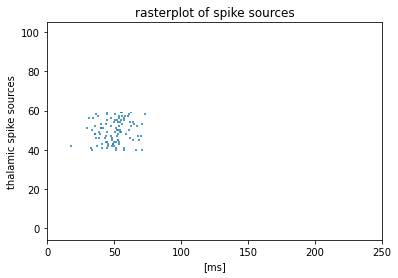

In [8]:
# make the thalamic input sources

n_pops['thal'] = n_pops['cx']

spike_times = [[]]*n_pops['thal'] #list of spike lists, where one spike list is related to one spike source

random_sources_idx = np.arange(int(n_pops['thal']*0.40), int(n_pops['thal']*0.60)) #[0,1,2]

for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([abs(np.random.normal(loc=50, scale=10)) for n in range(5)])

model_pops['thal'] = sim.SpikeSourceArray(spike_times)

pops['thal'] = sim.Population(n_pops['thal'], 
                              model_pops['thal'])


fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot of spike sources')
axes_list[0].set_xlim(0, simtime)

random_sources_idx

In [9]:
# make the projections

projs = {}

projs['thal', 'cx'] = sim.Projection(pops['thal'], 
                                    pops['cx'],
                                    connector = sim.OneToOneConnector(),
                                    synapse_type = synapses['thal', 'cx'],
                                    space = sim.Space(axes='x', periodic_boundaries=((0,500), None, None)),
                                    receptor_type = 'excitatory')

projs['cx', 'cx', 'exc'] = sim.Projection(pops['cx'], 
                                         pops['cx'],
                                         connector = conns['cx', 'cx', 'exc'],
                                         synapse_type = synapses['cx', 'cx', 'exc'],
                                         space = sim.Space(axes='x', periodic_boundaries=((0,500), None, None)),
                                         receptor_type = 'excitatory')

projs['cx', 'cx', 'inh'] = sim.Projection(pops['cx'], 
                                         pops['cx'],
                                         connector = conns['cx', 'cx', 'inh'],
                                         synapse_type = synapses['cx', 'cx', 'inh'],
                                         space = sim.Space(axes='x', periodic_boundaries=((0,500), None, None)),
                                         receptor_type = 'inhibitory')

In [10]:
# record state variables

pops['cx'].record(['spikes','v','gsyn_exc','gsyn_inh'])   

pops['thal'].record(['spikes'])


In [11]:
# run simulation

sim.run(simtime) 

2023-03-11 14:50:03 INFO: Simulating for 250 1.0ms timesteps using a hardware timestep of 1000us
2023-03-11 14:50:03 INFO: Starting execution process
2023-03-11 14:50:07 INFO: Time 0:00:03.136540 taken by SpallocMaxMachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2023-03-11 14:50:15 INFO: Time 0:00:08.000705 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2023-03-11 14:50:19 INFO: Time 0:00:04.891105 taken by PartitionAndPlacePartitioner
Created spalloc job 7064703
2023-03-11 14:50:19 INFO: Created spalloc job 7064703
Waiting for board power commands to complete.
2023-03-11 14:50:19 INFO: Waiting for board power commands to complete.
2023-03-11 14:50:28 INFO: Time 0:00:08.941713 taken by SpallocAllocator
2023-03-11 1

250.0

In [12]:
# save the results

outputs = {}

outputs['cx'] = pops['cx'].get_data()
for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
    pops['cx'].write_data(fileName + '_' + str(recording) + '.pkl')

outputs['thal'] = pops['thal'].get_data()
for recording in ['spikes']:
    pops['thal'].write_data(fileName + '_' + str(recording) + '.pkl')


Getting spikes for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting v for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting gsyn_exc for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting gsyn_inh for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting spikes for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting v for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting gsyn_exc for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting gsyn_inh for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting spikes for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting v for Abstrac

In [13]:
# recover results function

def recover_results(outputs):
    results = {}
    for key in outputs.keys(): # to extract the name of the layer, e.g., Exc, Inh, Thalamus, etc  
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results


In [14]:
# recover results

results = recover_results(outputs)
results.keys()

v
gsyn_exc
gsyn_inh


dict_keys([('cx', 'v'), ('cx', 'gsyn_exc'), ('cx', 'gsyn_inh'), ('cx', 'spikes'), ('thal', 'spikes')])

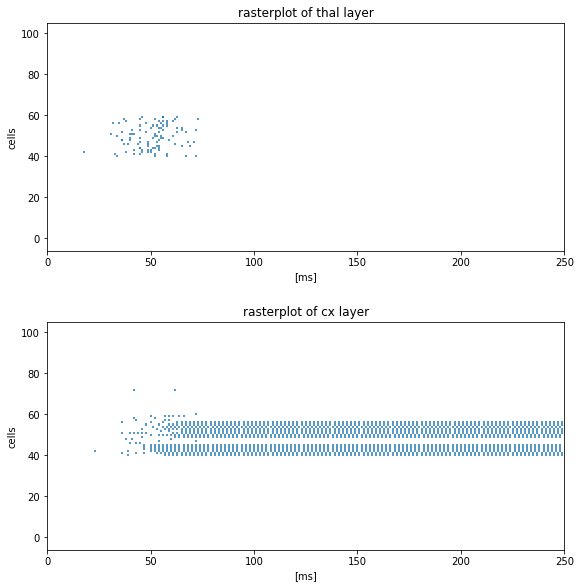

In [15]:
# check the spikes

fig, axes = plt.subplots(2,1, figsize=(9,9))
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['thal', 'cx']):
    axes_list[idx].eventplot(results[value, 'spikes'])
    axes_list[idx].set_title('rasterplot of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('[ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)



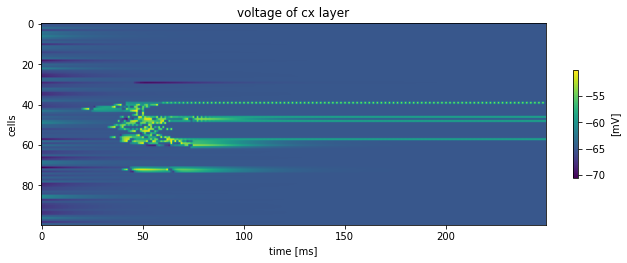

In [16]:
# check the voltage

fig, axes = plt.subplots(1, 1, figsize=(9,5))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['cx']):
    im = axes_list[idx].imshow(results[value, 'v'].T)
    axes_list[idx].set_title('voltage of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('cells')
    fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')



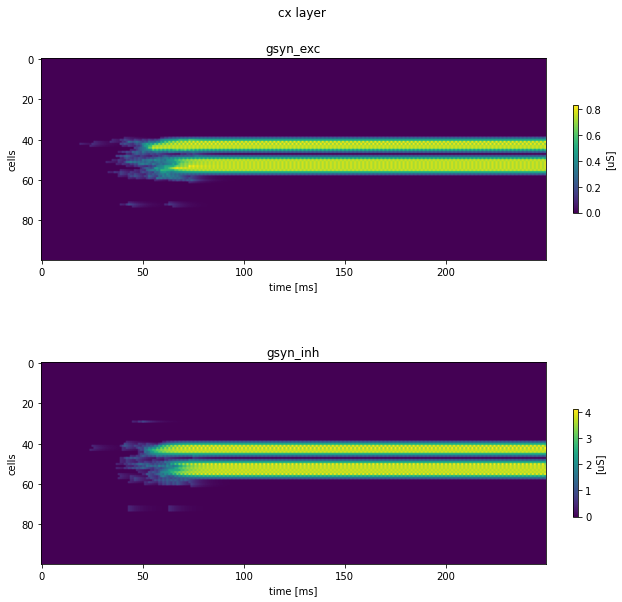

In [17]:
# check the conductances

for layer in ['cx']:
    fig, axes = plt.subplots(2, 1, figsize=(9,9))
    fig.tight_layout(pad=4)
    fig.suptitle(str(layer) + ' layer')
    axes_list = fig.axes
    
    for idx, gsyn in enumerate(['gsyn_exc', 'gsyn_inh']):
        im = axes_list[idx].imshow(results[layer, gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')


# check adjacent matrix

In [18]:
# check the small world projections

projs.keys()

dict_keys([('thal', 'cx'), ('cx', 'cx', 'exc'), ('cx', 'cx', 'inh')])

In [19]:
syn = {}

syn['exc'] = projs['cx', 'cx', 'exc'].get('source', 'target', 'list')
syn['inh'] = projs['cx', 'cx', 'inh'].get('source', 'target', 'list')



Getting ['source']s for projection between AbstractPopulationVertex_1 and AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting ['source']s for projection between AbstractPopulationVertex_1 and AbstractPopulationVertex_1
|0%                          50%                         100%|


In [20]:
syn['exc']

array([[ 0.,  0., nan, ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [nan,  2.,  2., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 97., 97., nan],
       [nan, nan, nan, ..., 98., 98., 98.],
       [nan, nan, nan, ..., nan, 99., 99.]])

In [21]:
syn['inh']

array([[ 0.,  0., nan, ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [nan,  2.,  2., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 97., 97., nan],
       [nan, nan, nan, ..., 98., 98., 98.],
       [nan, nan, nan, ..., nan, 99., 99.]])

In [22]:
# end simulation

sim.end()

2023-03-11 14:51:00 WARNING: The delays in the connector SmallWorldConnector from AbstractPopulationVertex_1 to AbstractPopulationVertex_1 was clipped to 1.0 a total of 65 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2023-03-11 14:51:00 WARNING: The delays in the connector SmallWorldConnector from AbstractPopulationVertex_1 to AbstractPopulationVertex_1 was clipped to 1.0 a total of 61 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep


# Task1: on the small-world network
- try to find in literature a 1D small-world network and use its parameter 
